In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.special
from scipy import misc
from scipy import ndimage

In [2]:
def binarise_array(data, thresh_scale=1, blur=10.0):
    threshold=thresh_scale*np.median(data)
    tdata=np.array([[0 if p<=threshold else 1 for p in row] for row in data])
    return tdata

def binarise_image(image, patch_size=100, thresh_scale=1, blur=10):    
    data=np.sum(image,2)
    norm=ndimage.gaussian_filter(data, sigma=blur)
    data=data.astype(float)/norm
    bin_image=np.empty_like(data)
    
    x_size=data.shape[1]
    y_size=data.shape[0]
    xs=range(0, x_size, patch_size)
    xs.append(x_size)
    ys=range(0, y_size, patch_size)
    ys.append(y_size)
    
    for j in range(len(ys)-1):
        for i in range(len(xs)-1):
            x0=xs[i]
            x1=xs[i+1]
            y0=ys[j]
            y1=ys[j+1]
            ba=binarise_array(data[y0:y1,x0:x1], thresh_scale, blur)
            bin_image[y0:y1,x0:x1]=ba
    return bin_image

    
def draw_line_at_binary_boundary(binary_image):
    lines=np.empty_like(binary_image)
    for i, row in enumerate(binary_image):
        for j, pixel in enumerate(row):
            if pixel==0:
                try:
                    up=binary_image[i+1,j]==1
                except IndexError:
                    up=False
                try:
                    if i==0:
                        down=False
                    else:
                        down=binary_image[i-1,j]==1
                except IndexError:
                    down=False
                try:
                    if j==0:
                        left=False
                    else:
                        left=binary_image[i,j-1]==1
                except IndexError:
                    left=False
                try:
                    right=binary_image[i,j+1]==1
                except IndexError:
                    right=False
                line=up or down or left or right
                if line:
                    lines[i,j]=0
                else:
                    lines[i,j]=255
            elif pixel==1:
                lines[i,j]=255
    return lines

def add_gray_border(image):
    b=np.zeros((image.shape[0]+2, image.shape[1]+2))
    b=b+130
    b[1:image.shape[0]+1, 1:image.shape[1]+1]=image
    return b

def circle_filter(input_array, inner_radius, outer_radius):
    mask=np.zeros_like(input_array)
    ys=mask.shape[0]/2
    xs=mask.shape[1]/2
    for j in np.arange(mask.shape[0]):
        for i in np.arange(mask.shape[1]):
            lower=inner_radius**2<((i-xs)**2+(j-ys)**2)
            upper=outer_radius**2>((i-xs)**2+(j-ys)**2)
            if lower and upper:
                mask[j,i]=1
    return mask

def gauss_filter(input_array, radius, sigma):
    y_mid=input_array.shape[0]/2
    x_mid=input_array.shape[1]/2
    ys=np.arange(-y_mid,y_mid)
    xs=np.arange(-x_mid,x_mid)
    X,Y=np.meshgrid(xs,ys)
    mask=np.exp(-np.abs((radius**2-X**2-Y**2))/float(sigma)**2)
    return mask

##Fringe Tracing

(-0.5, 3049.5, 1205.5, -0.5)

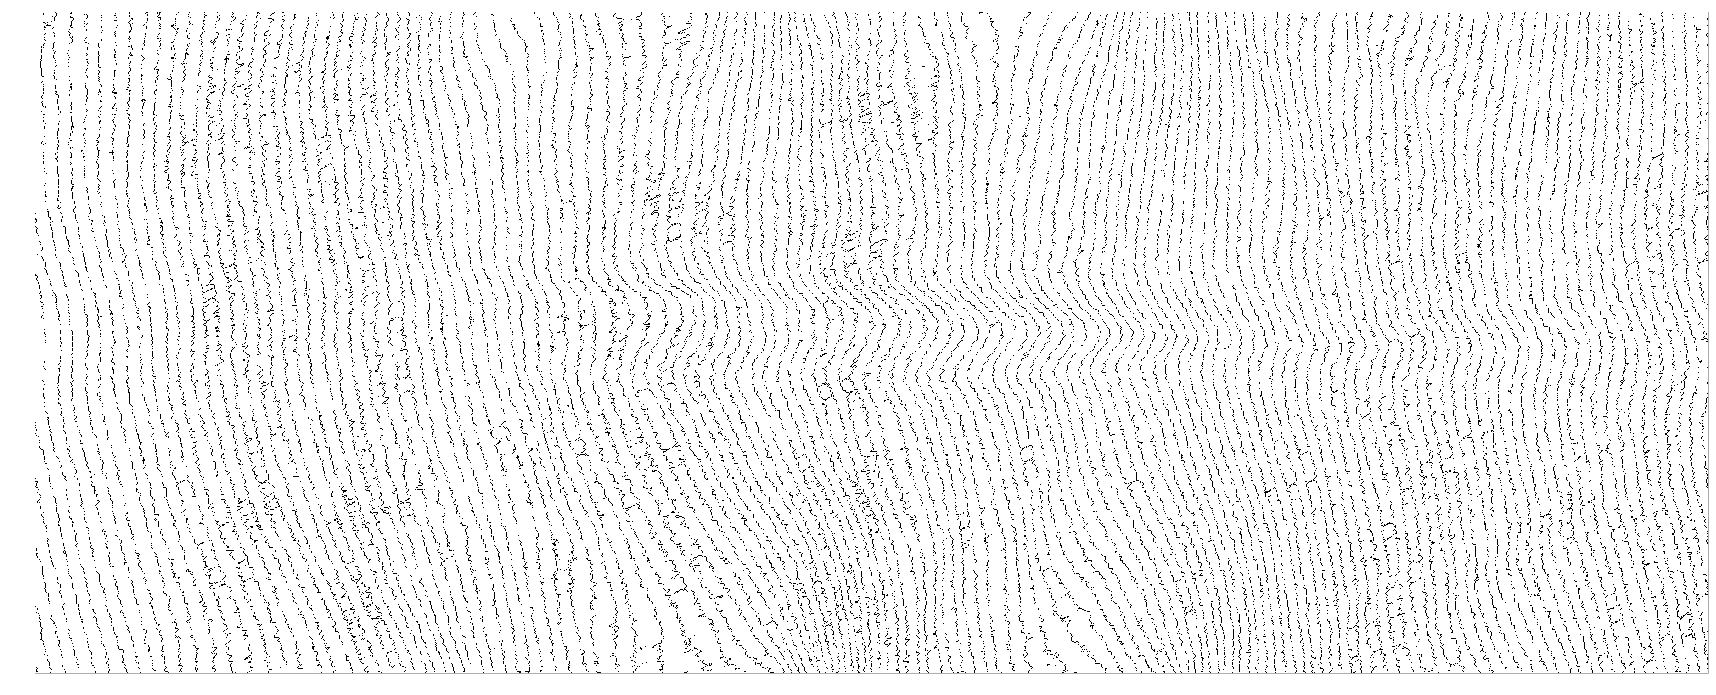

In [7]:
data = misc.imread('s0513_15 end on plasma.png')
bi=binarise_image(data, patch_size=200, blur=60, thresh_scale=1)
l=draw_line_at_binary_boundary(bi)
bl=add_gray_border(l)
fig, ax=plt.subplots(figsize=(30,30))
im=ax.imshow(bl, cmap='Greys_r', interpolation='none')
plt.axis('off')

In [21]:
im = Image.fromarray(np.uint8(bl))
im.save('plasma.png')

1.0016025235 1.04457711619


(array([  3.56000000e+02,   5.58000000e+03,   2.77920000e+04,
          6.02670000e+04,   7.52370000e+04,   7.24970000e+04,
          6.44620000e+04,   5.81640000e+04,   5.37410000e+04,
          5.10490000e+04,   5.03720000e+04,   5.05720000e+04,
          5.15400000e+04,   5.28550000e+04,   5.55380000e+04,
          5.98740000e+04,   6.64880000e+04,   7.67130000e+04,
          8.94650000e+04,   1.02006000e+05,   1.01093000e+05,
          7.69290000e+04,   4.53770000e+04,   2.18730000e+04,
          8.32800000e+03,   2.59700000e+03,   6.02000000e+02,
          1.13000000e+02,   1.60000000e+01,   4.00000000e+00]),
 array([ 0.26804124,  0.32235114,  0.37666105,  0.43097095,  0.48528086,
         0.53959076,  0.59390067,  0.64821058,  0.70252048,  0.75683039,
         0.81114029,  0.8654502 ,  0.9197601 ,  0.97407001,  1.02837991,
         1.08268982,  1.13699973,  1.19130963,  1.24561954,  1.29992944,
         1.35423935,  1.40854925,  1.46285916,  1.51716906,  1.57147897,
         1.62

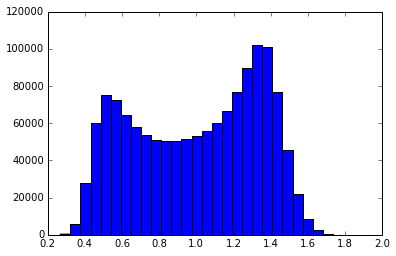

In [27]:
data_flat=np.sum(data,2)
norm=ndimage.gaussian_filter(data_flat, sigma=15)
nd=data_flat.astype(float)/norm
print nd.mean(), np.median(nd)
plt.hist(nd.flatten(), bins=30)

(-0.5, 3101.5, 959.5, -0.5)

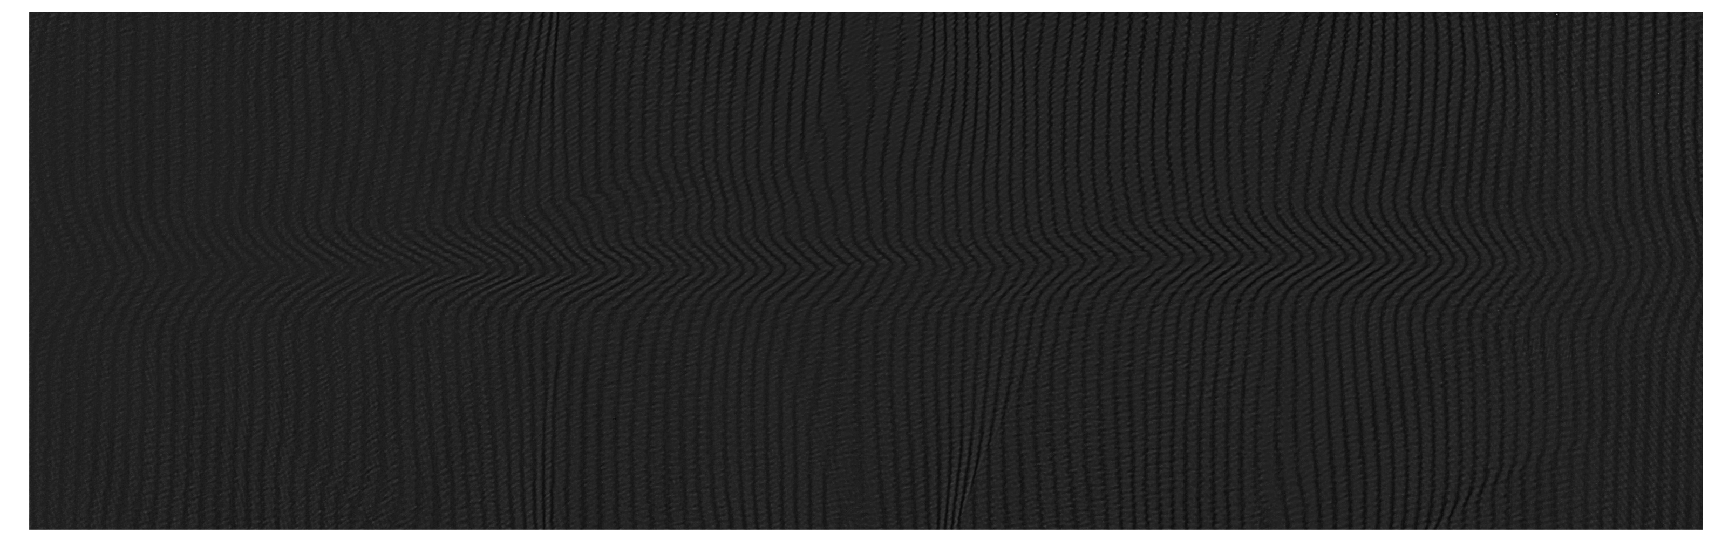

In [29]:
data = misc.imread('endon_plasma.png')
data=np.sum(data,2)
norm=ndimage.gaussian_filter(data, sigma=3)
data=data.astype(float)/norm
fig, ax=plt.subplots(figsize=(30,30))
im=ax.imshow(data, cmap='Greys_r', interpolation='none')
plt.axis('off')

##Fourier Transforms

In [3]:
data = misc.imread('s0513_15 end on vacuum.png')
d=np.sum(data,2)

In [4]:
ft=np.fft.fft2(d)
laft=np.log(np.abs(ft))
sh_ft=np.fft.fftshift(ft)

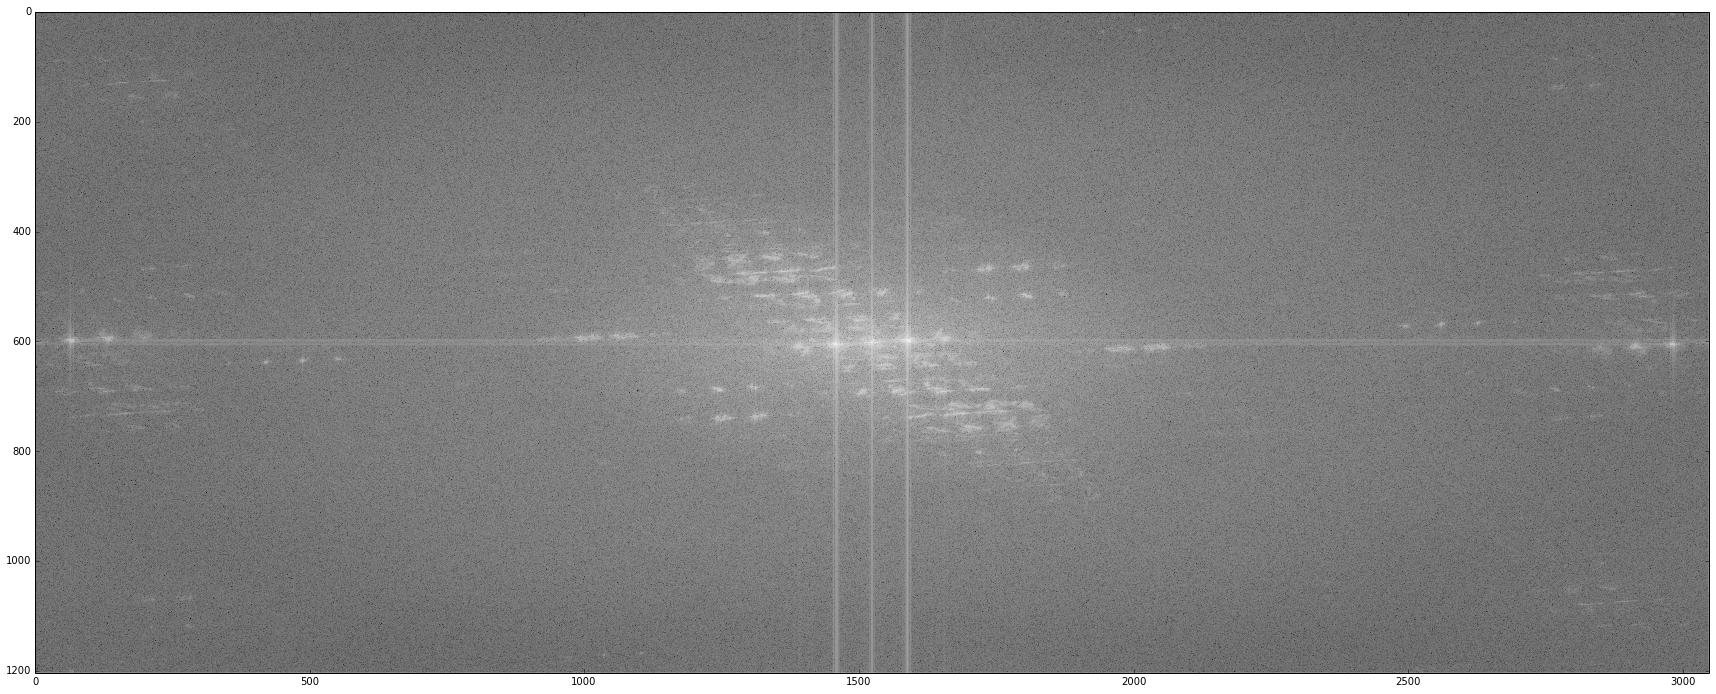

In [5]:
fig, ax=plt.subplots(figsize=(30,30))
im=ax.imshow(np.fft.fftshift(laft), cmap='Greys_r', interpolation='none')

In [ ]:
gf=gauss_filter(d, 50, 50)
f_fft=np.fft.ifftshift(gf*sh_ft)
f_im=np.fft.ifft2(f_fft)
plt.imshow(gf, cmap='Greys_r', interpolation='none')

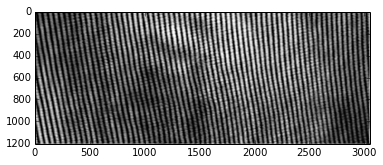

In [6]:
#fig2, ax2=plt.subplots(figsize=(30,30))
plt.imshow(np.abs(f_im), cmap='Greys_r', interpolation='none')

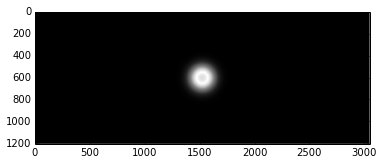

In [7]:
plt.imshow(gf, cmap='Greys_r', interpolation='none')